In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import defaultdict
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [2]:
df = pd.read_csv('complessivo_rms_finale.csv', index_col='id')
df0 = pd.read_csv('flat_df_no_nulli.csv', index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
2,0.005965,0.030530,0.038409,0.052510,0.081335,0.096664,0.092021,0.083451,0.083296,0.086539,...,0.167174,0.126127,0.111858,0.095006,0.099327,0.097803,0.107587,0.152822,0.177150,0.000000
3,0.009710,0.088201,0.120011,0.128533,0.150989,0.169258,0.205793,0.261233,0.279276,0.259404,...,0.126499,0.103162,0.147984,0.207548,0.256682,0.254089,0.194205,0.146202,0.119663,0.121850
5,0.004292,0.036312,0.051975,0.046670,0.203390,0.283229,0.314644,0.322023,0.293859,0.251127,...,0.318426,0.312173,0.305558,0.281919,0.234308,0.178978,0.163058,0.143980,0.120217,0.107188
10,0.110271,0.142744,0.156790,0.131847,0.125279,0.129176,0.128395,0.171358,0.298087,0.304533,...,0.296138,0.217364,0.184314,0.176318,0.161866,0.158079,0.158619,0.148111,0.146005,0.000000
20,0.245351,0.239747,0.211342,0.181047,0.184478,0.177384,0.142504,0.206317,0.242042,0.226818,...,0.333991,0.285059,0.176683,0.181024,0.188473,0.168699,0.164692,0.181571,0.183699,0.000000


# Preprocessing

In [3]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

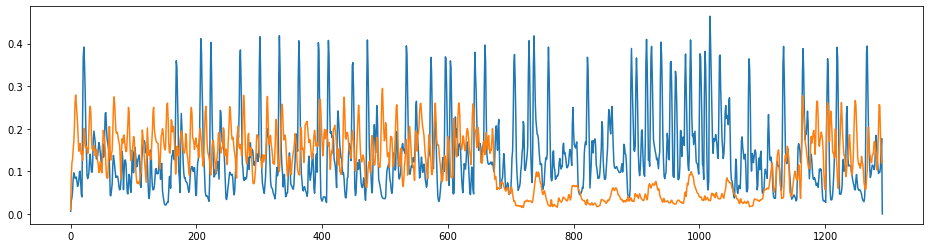

In [4]:
plt.figure(figsize=(16, 4))

ts1 = df[df.index==2].T.values
ts2 = df[df.index==3].T.values

plt.plot(ts1)
plt.plot(ts2)
plt.show()

## Amplitude Scaling

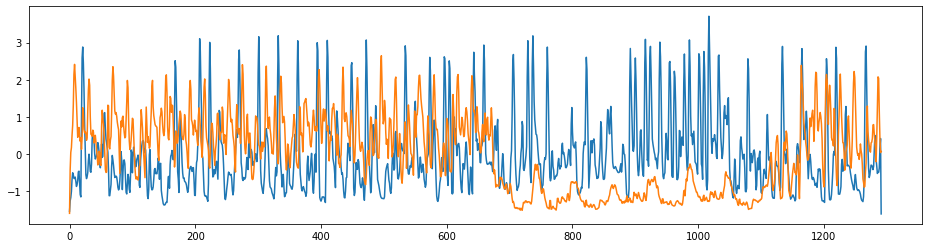

In [5]:
plt.figure(figsize=(16, 4))

scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)  # Rescale time series
ts1_scaled = scaler.fit_transform(ts1.reshape(1, -1)).flatten()
ts2_scaled = scaler.fit_transform(ts2.reshape(1, -1)).flatten()

plt.plot(ts1_scaled)
plt.plot(ts2_scaled)
plt.show()

## Noise (smoothing)

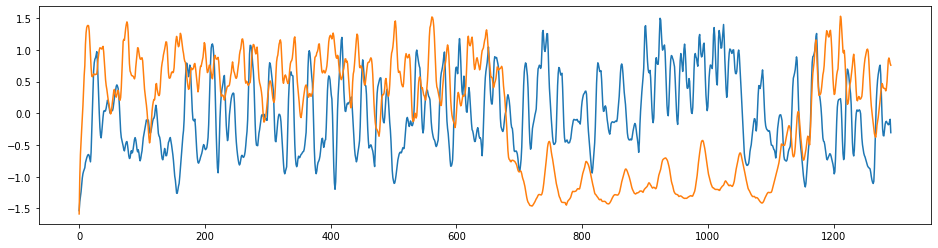

In [6]:
plt.figure(figsize=(16, 4))
w = 10

ts1_ = pd.Series(ts1.reshape(1, -1).squeeze())
ts2_ = pd.Series(ts2.reshape(1, -1).squeeze())

plt.plot(((ts1_ - ts1_.mean())/ts1_.std()).rolling(window=w, min_periods=1).mean())
plt.plot(((ts2_ - ts2_.mean())/ts2_.std()).rolling(window=w, min_periods=1).mean())
plt.show()

In [43]:
#Amplitude scaling
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
df = df.T.apply(lambda x: scaler.fit_transform(x.values.reshape(1, -1)).flatten()).T

In [44]:
#Noise
w = 10
df = df.T.apply(lambda x: ((x - x.mean())/x.std()).rolling(window=w, min_periods=1).mean()).T

# TS Approximation

In [7]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [8]:
ts = df[df.index==2].T.values.reshape(1,-1)

C:\Users\Francesco\Anaconda3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
C:\Users\Francesco\Anaconda3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
C:\Users\Francesco\Anaconda3\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


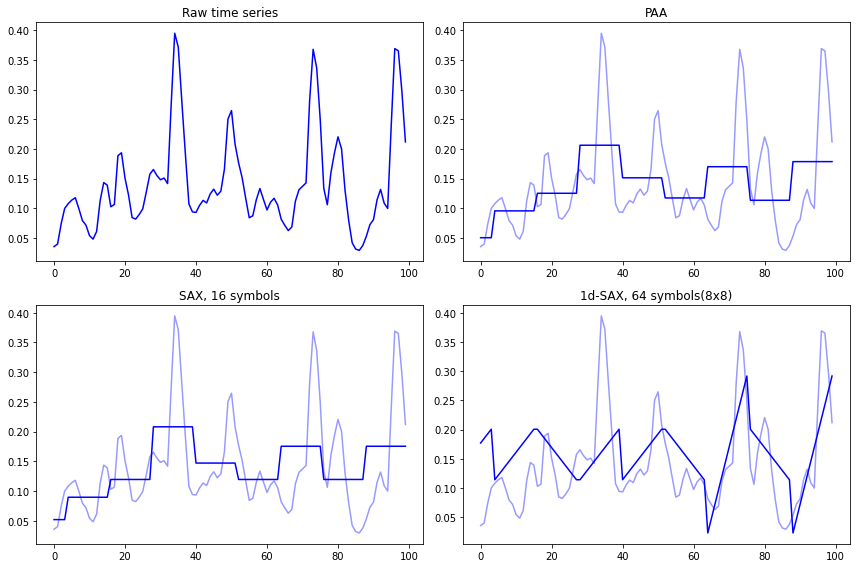

In [9]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 100
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(ts)
paa_dataset_inv = paa.inverse_transform(ts_paa)

# SAX transform
n_sax_symbols = 16
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols, scale=True)
ts_sax = sax.fit_transform(ts)
sax_dataset_inv = sax.inverse_transform(ts_sax)

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 8
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)

ts_sax1d = one_d_sax.fit_transform(ts)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(ts_sax1d)

plt.figure(figsize=(12, 8)) 
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(ts[0].ravel()[500:600], "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel()[500:600], "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel()[500:600], "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel()[500:600], "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

In [10]:
import warnings
import tqdm as tq
warnings.filterwarnings("ignore")

In [16]:
paa = PiecewiseAggregateApproximation(n_segments=100)

In [17]:
id_list = []
values_list = []
ex = []

for i in tq.tqdm(df.index):
    try:
        values_list.append(paa.fit_transform(df[df.index==i].T.values.reshape(1,-1))[0,:,0])
        id_list.append(i)
    except:
        ex.append(i)

100%|█████████████████████████████████████████████████████████████████████████| 106412/106412 [02:21<00:00, 752.69it/s]


In [18]:
df_approssimato = pd.DataFrame(data=values_list, index=id_list)

In [19]:
df_approssimato

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2,-1.063012,-0.378446,0.425916,0.033017,0.150339,-0.087710,-0.577289,-0.528511,-0.446417,-0.179468,...,0.384126,-0.339522,-0.379817,-0.504463,0.019878,-0.039119,-0.796648,0.869420,-0.114327,-0.700066
3,0.014221,0.995628,0.804789,0.636206,0.192957,0.521068,1.083118,0.746884,0.614796,-0.115630,...,-1.382764,-1.251889,-0.917870,-0.448158,-0.442310,-0.268748,-0.523371,0.691069,0.545334,1.136028
5,-0.409365,0.233493,-0.154301,-0.393842,0.980051,-0.357605,-0.056170,-0.456842,0.977428,0.550632,...,0.263550,-0.074440,-0.432167,-0.306305,0.821702,0.729985,0.202820,-0.863294,0.085117,-0.100107
10,-0.806781,-0.329477,-0.418514,0.039598,-0.355800,-0.787906,-0.397974,-0.421388,-0.085806,-0.533490,...,-0.340388,-0.194084,-0.105177,0.168291,0.016004,0.077183,-0.419088,0.238079,-0.241467,0.534076
20,0.385180,0.805499,-0.266433,-0.158946,0.295217,-0.266670,0.329794,-0.496221,0.907315,0.589161,...,-0.172556,-0.910591,-0.087648,0.433970,1.334203,1.035461,0.620535,0.688058,0.368913,0.363428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148531,0.335927,1.066105,0.390648,-0.796923,0.179508,-0.235022,-0.888049,-1.065139,-0.932360,-1.727303,...,0.178437,0.519667,0.937368,0.699641,-0.215144,-0.306399,0.539079,0.194502,0.844774,0.656468
148532,-0.266527,0.786347,0.912746,0.202720,0.158320,1.979581,1.033920,0.385348,-0.749971,-0.532672,...,-0.523338,-1.298892,-0.312120,0.613477,-0.018867,0.403054,-0.043203,-0.882864,-0.154994,-0.155415
148533,-0.262287,0.186275,0.282665,0.851774,0.167327,1.066599,0.725673,1.404498,0.193719,0.550371,...,0.751087,-0.432827,0.513610,-0.036069,-0.046865,-0.006461,0.567903,-0.297615,-0.844063,-0.363696
148534,-1.122001,-0.490855,-0.010177,1.230833,0.365309,0.548412,-0.023110,-0.555006,-0.760622,-0.356738,...,0.118543,0.074849,-0.796046,-0.452740,-0.434151,1.075671,0.730233,1.113732,0.859832,0.035264


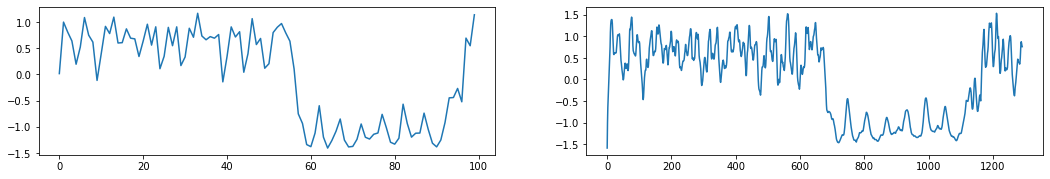

In [20]:
plt.figure(figsize=(18, 6)) 
plt.subplot(2,2,1)
plt.plot(df_approssimato.T[3])
plt.subplot(2,2,2)
plt.plot(df.T[3].values)
plt.show()

In [112]:
#df_approssimato.to_csv("rms_approssimato.csv")

In [11]:
df0[df0["TRACK_genre_top"] == "Rock"].groupby("ARTIST_name").size().sort_values(ascending=False)

ARTIST_name
Disco Missile            144
Obits                    126
+HIRS+                   100
King Ghidorah!            86
Glove Compartment         75
                        ... 
Seven Lines                1
Krallice                   1
Delusions of Grandeur      1
Male Nudity                1
Jaw Horse                  1
Length: 2054, dtype: int64

In [12]:
indici_disco_missile  = df0[df0["ARTIST_name"] == "Disco Missile"].index
indici_obits  = df0[df0["ARTIST_name"] == "Obits"].index

In [13]:
df_disco_missile = df[df.index.isin(indici_disco_missile)]
df_disco_missile = df_disco_missile.dropna()
df_obits = df[df.index.isin(indici_obits)]
df_obits = df_obits.dropna()
df_artist = df_disco_missile.append(df_obits)
df_artist

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
60996,0.079494,0.081734,0.075735,0.061968,0.059141,0.060817,0.063131,0.065757,0.060411,0.052072,...,0.081678,0.080125,0.085552,0.083689,0.083882,0.089773,0.087827,0.087585,0.091495,0.000000
60997,0.132267,0.123606,0.110993,0.100210,0.098106,0.100713,0.093811,0.086690,0.107070,0.117847,...,0.109924,0.100958,0.095521,0.087558,0.084769,0.091913,0.092564,0.115728,0.119241,0.000000
60998,0.068514,0.066535,0.067427,0.067935,0.077420,0.085394,0.074942,0.079198,0.083866,0.086231,...,0.085086,0.078716,0.076370,0.073892,0.067862,0.068963,0.081844,0.087812,0.081375,0.000000
60999,0.031553,0.032455,0.033646,0.031248,0.031271,0.038849,0.040205,0.059949,0.071922,0.065457,...,0.044795,0.038220,0.031230,0.022417,0.025700,0.037426,0.043717,0.042143,0.042012,0.042856
61000,0.062222,0.062179,0.055895,0.052227,0.050747,0.050020,0.056955,0.061197,0.063521,0.062486,...,0.039041,0.058771,0.085461,0.082293,0.074241,0.076553,0.066309,0.066682,0.077542,0.075072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91325,0.044188,0.074328,0.091884,0.077916,0.060215,0.139572,0.173242,0.158110,0.150443,0.144419,...,0.109388,0.103390,0.107187,0.105747,0.104813,0.104638,0.088611,0.079444,0.094967,0.129824
91326,0.107466,0.135299,0.161708,0.169637,0.170690,0.162734,0.160456,0.190344,0.215656,0.190510,...,0.116635,0.127911,0.131730,0.126733,0.121042,0.118793,0.116713,0.114698,0.144570,0.000000
91327,0.098298,0.128946,0.176949,0.203683,0.190704,0.155830,0.142974,0.141065,0.150103,0.172054,...,0.109148,0.202319,0.268042,0.227831,0.170670,0.162239,0.158512,0.165034,0.164543,0.000000


In [14]:
indici_rock  = df0[df0["TRACK_genre_top"] == "Rock"].index
indici_classical  = df0[df0["TRACK_genre_top"] == "Classical"].index
indici_other  = df0[df0["TRACK_genre_top"] != "Rock"].index

In [15]:
df_rock_appr = df_approssimato[df_approssimato.index.isin(indici_rock)]
df_rock_appr = df_rock_appr.dropna()
df_other_appr = df_approssimato[df_approssimato.index.isin(indici_other)]
df_other_appr = df_other_appr.dropna()
df_unito_appr = df_rock_appr[:2000].append(df_other_appr[:2000])

NameError: name 'df_approssimato' is not defined

In [219]:
df_rock = df[df.index.isin(indici_rock)]
df_rock = df_rock.dropna()
df_classical = df[df.index.isin(indici_classical)]
df_classical = df_classical.dropna()
df_other = df[df.index.isin(indici_other)]
df_other = df_other.dropna()
df_unito = df_rock[5000:6212].append(df_classical)
#df_unito = df_rock.append(df_classical)

In [220]:
print("df_rock: ", df_rock.shape)
print("df_classical: ", df_classical.shape)
print("df_other: ", df_other.shape)
df_unito

df_rock:  (14143, 1292)
df_classical:  (1212, 1292)
df_other:  (91207, 1292)


,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
52569,-0.051218,-0.036186,-0.089198,-0.225202,-0.392225,-0.557081,-0.510310,-0.229229,0.018227,0.102387,...,0.419787,0.586032,0.594201,0.501670,0.401714,0.300588,0.194387,0.076844,0.071489,-0.233595
52693,-5.313471,-3.460349,-2.213990,-1.652568,-1.421472,-1.217325,-1.104433,-1.096123,-1.124684,-1.148150,...,-0.137027,-0.070498,0.001720,0.068961,0.140704,0.140819,0.051931,-0.065366,-0.160231,-0.194104
52694,-4.502345,-2.805393,-1.660132,-1.142092,-0.601339,-0.148290,-0.016126,-0.017624,-0.060165,-0.122034,...,-0.810745,-0.820843,-0.848508,-0.802280,-0.693873,-0.636864,-0.558294,-0.239846,0.089399,0.180840
52695,-2.679684,-1.904911,-1.278323,-0.884047,-0.676365,-0.551937,-0.475520,-0.412019,-0.353071,-0.326512,...,0.199414,0.089777,-0.136314,-0.360350,-0.558715,-0.761324,-0.982053,-1.181542,-1.408301,-1.575060
52696,-5.136516,-3.169162,-1.961591,-1.434708,-1.268869,-1.132340,-0.935220,-0.825178,-0.729086,-0.647441,...,-0.479379,-0.559615,-0.561954,-0.373812,-0.153789,-0.103108,-0.088188,-0.081288,0.023335,0.153264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146001,-1.541472,-0.941820,-0.553598,-0.451177,-0.458732,-0.390581,-0.298432,-0.238412,-0.222288,-0.231726,...,-1.398570,-1.404648,-1.407001,-1.409515,-1.416972,-1.429426,-1.432241,-1.413014,-1.178854,-1.242538
146002,-1.394816,-0.754440,-0.302352,-0.079825,0.055701,0.122048,0.124668,0.102762,0.049098,0.046755,...,-0.205557,-0.243182,-0.285079,-0.330879,-0.389608,-0.453661,-0.505297,-0.540700,-0.568926,-0.697153
148488,-5.781991,-4.074444,-2.990037,-2.295905,-1.609698,-1.087858,-0.832514,-0.731765,-0.653096,-0.585614,...,0.351881,0.263930,0.117964,-0.001954,0.188419,0.619805,0.821049,0.803029,0.828543,0.802045


# Clustering

## Shape-based Clustering

In [268]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from scipy.stats import entropy

In [295]:
#X = df_unito_appr.values
#X = df_rock.values
#X = df_artist
X = df_unito.values
paa = PiecewiseAggregateApproximation(n_segments=100)
X_paa = paa.fit_transform(X)

In [310]:
n_clusters=5
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=50, random_state=0, n_jobs=-1, verbose=True)
km.fit(X_paa)

73.176 --> 50.196 --> 48.236 --> 47.777 --> 47.578 --> 47.465 --> 47.394 --> 47.333 --> 47.288 --> 47.248 --> 47.223 --> 47.203 --> 47.186 --> 47.175 --> 47.168 --> 47.163 --> 47.160 --> 47.158 --> 47.156 --> 47.155 --> 47.154 --> 47.153 --> 47.153 --> 47.152 --> 47.152 --> 47.151 --> 47.150 --> 47.150 --> 47.150 --> 47.149 --> 47.149 --> 47.148 --> 47.148 --> 47.147 --> 47.147 --> 47.147 --> 47.146 --> 47.146 --> 


TimeSeriesKMeans(n_clusters=5, n_jobs=-1, random_state=0, verbose=True)

In [311]:
km.cluster_centers_.shape

(5, 100, 1)

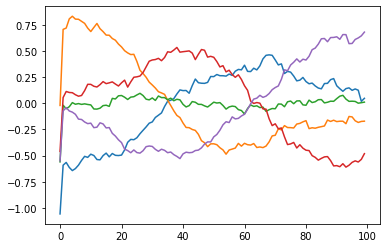

In [312]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [313]:
silhouette_avg = silhouette_score(X, km.labels_)
silhouette_avg

0.0370673561464681

In [314]:
km.inertia_

47.146433179890394

In [315]:
unique, counts = np.unique(km.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4], dtype=int64),
 array([408, 327, 926, 384, 379], dtype=int64))

In [316]:
for i in range(n_clusters):
    n_rock = (np.where(km.labels_ == i)[0] < 1212).sum()
    n_classical = (np.where(km.labels_ == i)[0] > 1212).sum()
    totale = (km.labels_ == i).sum()
    
    print("#Rock in cluster", i ,"=", n_rock, 
          "#Classical in cluster", i ,"=", n_classical,
          "Rapporto =", n_rock/n_classical
          #"Entropia =", entropy([n_rock/totale, n_classical/totale])
         )

#Rock in cluster 0 = 182 #Classical in cluster 0 = 226 Rapporto = 0.8053097345132744
#Rock in cluster 1 = 122 #Classical in cluster 1 = 205 Rapporto = 0.5951219512195122
#Rock in cluster 2 = 603 #Classical in cluster 2 = 323 Rapporto = 1.86687306501548
#Rock in cluster 3 = 161 #Classical in cluster 3 = 223 Rapporto = 0.7219730941704036
#Rock in cluster 4 = 144 #Classical in cluster 4 = 234 Rapporto = 0.6153846153846154


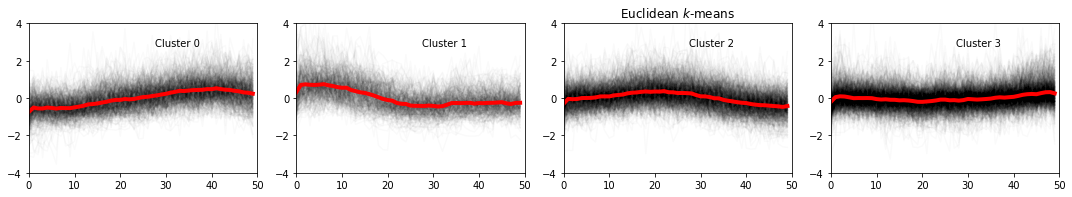

In [267]:
sz = X_paa.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_paa[km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

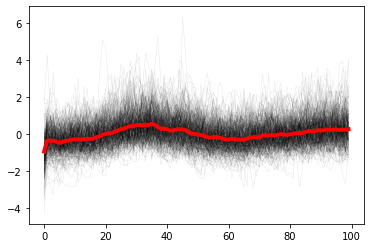

In [148]:
plt.plot(X_paa[np.where(km.labels_ == 0)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km.cluster_centers_[0]).T, linewidth=4, c="r")
plt.show()

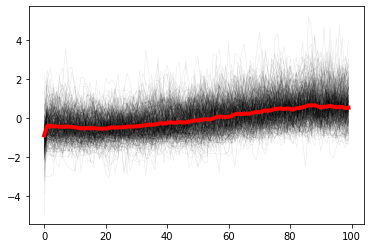

In [149]:
plt.plot(X_paa[np.where(km.labels_ == 1)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km.cluster_centers_[1]).T, linewidth=4, c="r")
plt.show()

In [365]:
#X = df_rock
#X = df_unito_appr
X = df_unito.values
#X = df_artist
paa = PiecewiseAggregateApproximation(n_segments=100)
X_paa = paa.fit_transform(X)

In [366]:
n_clusters=5
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0, n_jobs=-1, max_iter_barycenter=10, verbose=True)
km_dtw.fit(X_paa)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2424 out of 2424 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=

20.027 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

15.661 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

15.238 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

15.051 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

14.988 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw', n_clusters=5,
                 n_jobs=-1, random_state=0, verbose=True)

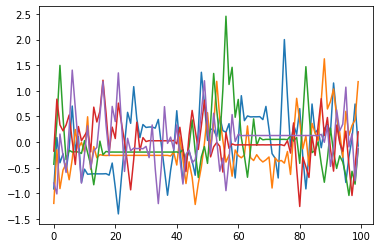

In [367]:
plt.plot(np.squeeze(km_dtw.cluster_centers_).T)
plt.show()

In [368]:
km_dtw.labels_

array([3, 0, 4, ..., 3, 1, 1], dtype=int64)

In [369]:
km_dtw.inertia_

14.987589274035669

In [370]:
for i in range(n_clusters):
    n_rock = (np.where(km_dtw.labels_ == i)[0] < 1212).sum()
    n_classical = (np.where(km_dtw.labels_ == i)[0] > 1212).sum()
    totale = (km_dtw.labels_ == i).sum()
    
    print("#Rock in cluster", i ,"=", n_rock, 
          "#Classical in cluster", i ,"=", n_classical,
          "Rapporto =", n_rock/n_classical
          #"Entropia =", entropy([n_rock/totale, n_classical/totale])
         )

#Rock in cluster 0 = 127 #Classical in cluster 0 = 194 Rapporto = 0.654639175257732
#Rock in cluster 1 = 238 #Classical in cluster 1 = 229 Rapporto = 1.039301310043668
#Rock in cluster 2 = 107 #Classical in cluster 2 = 384 Rapporto = 0.2786458333333333
#Rock in cluster 3 = 526 #Classical in cluster 3 = 137 Rapporto = 3.8394160583941606
#Rock in cluster 4 = 214 #Classical in cluster 4 = 267 Rapporto = 0.8014981273408239


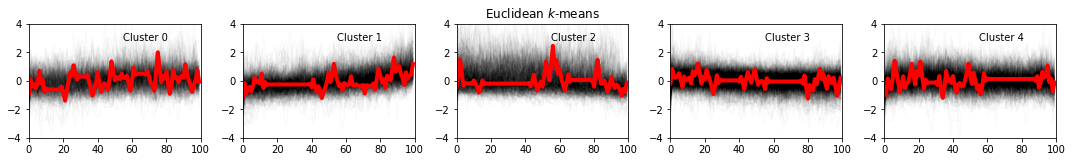

In [371]:
sz = X_paa.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_paa[km_dtw.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km_dtw.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

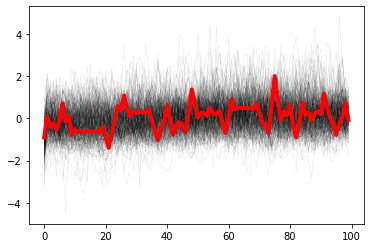

In [373]:
plt.plot(X_paa[np.where(km_dtw.labels_ == 0)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km_dtw.cluster_centers_[0]).T, linewidth=4, c="r")
plt.show()

In [822]:
n_clusters=3
km_sdtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=5, random_state=0, n_jobs=-1, verbose=True)
km_sdtw.fit(X_paa)

6929.339 --> 6975.298 --> 6978.145 --> 6980.127 --> 6981.743 --> 


TimeSeriesKMeans(max_iter=5, metric='softdtw', n_jobs=-1, random_state=0,
                 verbose=True)

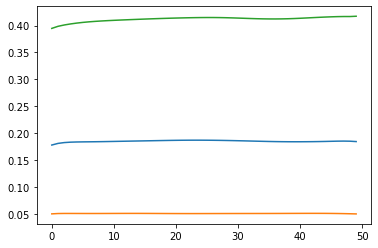

In [823]:
plt.plot(np.squeeze(km_sdtw.cluster_centers_).T)
plt.show()

In [824]:
km_sdtw.labels_

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [825]:
km_sdtw.inertia_

6981.7425266135515

In [826]:
for i in range(n_clusters):
    print("#Rock in cluster", i ,"=",(np.where(km_dtw.labels_ == i)[0] < 1000).sum(), 
          "#Classical in cluster", i ,"=",(np.where(km_dtw.labels_ == i)[0] > 1000).sum())

#Rock in cluster 0 = 683 #Classical in cluster 0 = 75
#Rock in cluster 1 = 224 #Classical in cluster 1 = 1136
#Rock in cluster 2 = 93 #Classical in cluster 2 = 0


In [649]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

## Features-based Clustering

In [827]:
from sklearn.cluster import KMeans

In [828]:
F = [list(calculate_features(x).values())[:-2] for x in X]

TypeError: cannot perform reduce with flexible type

In [646]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(F)

KMeans(n_clusters=5)

In [647]:
kmeans.inertia_

1907.7272033847942

In [648]:
for i in range(5):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

KeyError: "None of [Int64Index([   20,    28,    57,    61,    62,    78,    91,    97,   101,\n              102,\n            ...\n            14081, 14092, 14099, 14101, 14105, 14121, 14128, 14130, 14139,\n            14140],\n           dtype='int64', length=3364)] are in the [columns]"

In [829]:
X = df_unito.values
sz = X.shape[1]

Euclidean k-means
67.928 --> 39.675 --> 38.863 --> 38.698 --> 38.644 --> 38.612 --> 38.580 --> 38.559 --> 38.536 --> 38.516 --> 38.494 --> 38.455 --> 38.410 --> 38.371 --> 38.343 --> 38.315 --> 38.300 --> 38.297 --> 38.293 --> 38.289 --> 38.283 --> 38.278 --> 38.275 --> 38.274 --> 38.273 --> 38.273 --> 
DBA k-means


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parall

17.600 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


14.320 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


14.097 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


13.960 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


13.886 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


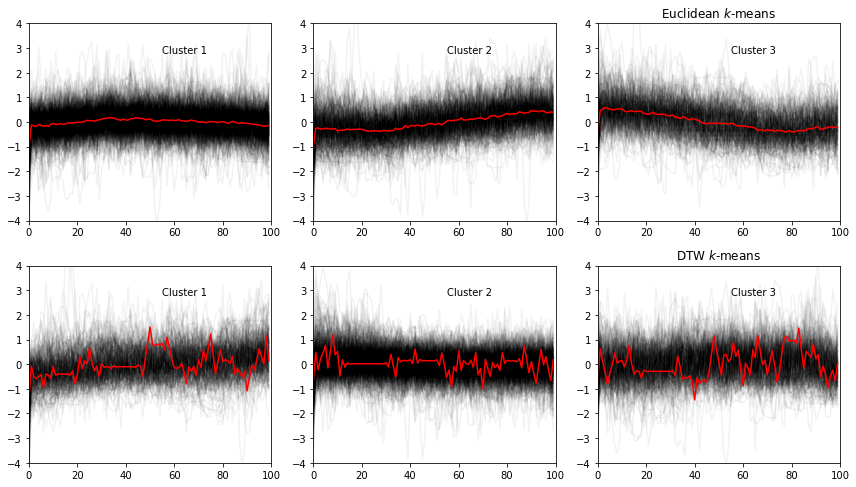

In [145]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=0, n_jobs=-1, max_iter=50)
km.fit(X)

plt.figure(figsize=(12, 10)) 
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X[km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(np.squeeze(km.cluster_centers_[yi]).T, "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=0,
                          n_jobs=-1,
                          max_iter=5)
dba_km.fit(X)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X[dba_km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(np.squeeze(dba_km.cluster_centers_[yi]).T, "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("DTW $k$-means")

plt.tight_layout()
plt.show()

# Motif

In [596]:
X = df_rock.values
#paa = PiecewiseAggregateApproximation(n_segments=200)
#X_paa = paa.fit_transform(X)

In [597]:
#one_d_sax = OneD_SymbolicAggregateApproximation(n_segments=100,alphabet_size_avg=8,alphabet_size_slope=8)
#X_paa = one_d_sax.fit_transform(X)[:,:,0]

In [598]:
n_clusters=6
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=50, random_state=0, n_jobs=-1, verbose=True)
km.fit(X)

865.329 --> 586.631 --> 574.997 --> 571.831 --> 570.515 --> 569.952 --> 569.705 --> 569.571 --> 569.487 --> 569.428 --> 569.384 --> 569.350 --> 569.328 --> 569.308 --> 569.289 --> 569.272 --> 569.260 --> 569.248 --> 569.235 --> 569.221 --> 569.207 --> 569.196 --> 569.186 --> 569.178 --> 569.171 --> 569.161 --> 569.151 --> 569.138 --> 569.123 --> 569.105 --> 569.088 --> 569.070 --> 569.053 --> 569.031 --> 569.009 --> 568.981 --> 568.951 --> 568.914 --> 568.865 --> 568.814 --> 568.764 --> 568.702 --> 568.647 --> 568.601 --> 568.556 --> 568.507 --> 568.457 --> 568.421 --> 568.388 --> 568.362 --> 


TimeSeriesKMeans(n_clusters=6, n_jobs=-1, random_state=0, verbose=True)

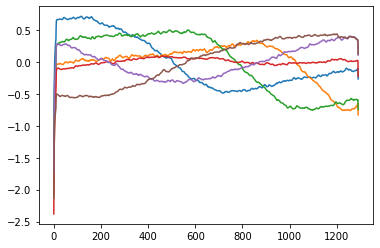

In [599]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [600]:
unique, counts = np.unique(km.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([1428, 1535, 1084, 5657, 2311, 2128], dtype=int64))

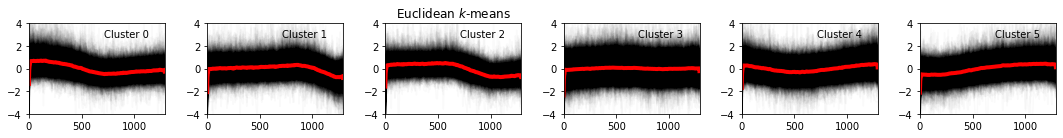

In [601]:
sz = X.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X[km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

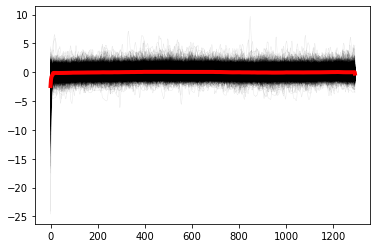

In [602]:
plt.plot(X[np.where(km.labels_ == 3)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km.cluster_centers_[3]).T, linewidth=4, c="r")
plt.show()

In [614]:
#Risultato clustering per motif discovery?
ts1 = np.squeeze(km.cluster_centers_[3]).T
#ts2 = np.squeeze(km.cluster_centers_[2]).T

In [608]:
X = df_rock[5500:6000].values
paa = PiecewiseAggregateApproximation(n_segments=200)
X_paa = paa.fit_transform(X)

In [609]:
n_clusters=4
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0, n_jobs=-1, max_iter_barycenter=10, verbose=True)
km_dtw.fit(X_paa)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 

29.611 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


23.048 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


22.777 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.9s finished


22.692 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.9s finished


22.682 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.6s finished


TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw', n_clusters=4,
                 n_jobs=-1, random_state=0, verbose=True)

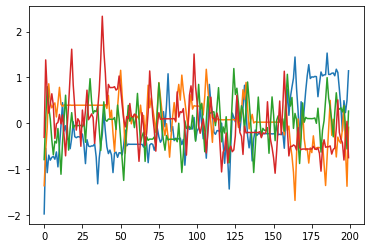

In [610]:
plt.plot(np.squeeze(km_dtw.cluster_centers_).T)
plt.show()

In [611]:
unique, counts = np.unique(km_dtw.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3], dtype=int64), array([ 73,  85, 254,  88], dtype=int64))

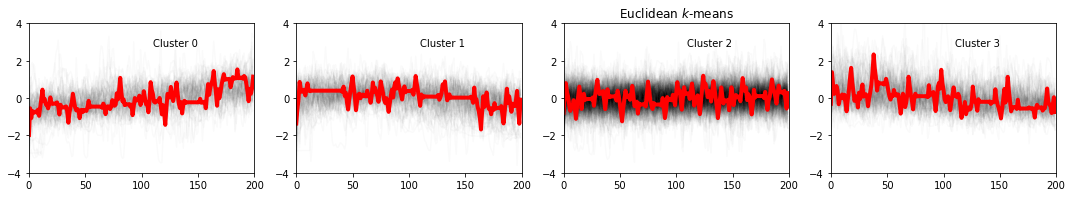

In [612]:
sz = X_paa.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_paa[km_dtw.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km_dtw.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

In [617]:
ts2 = np.squeeze(km_dtw.cluster_centers_[2]).T

In [564]:
import pickle
pickle.dump(km_dtw, open("dtw.pickle", 'wb'))

#TimeSeriesKMeans = pickle.load(open("TimeSeriesKMeans.pickle", 'rb'))

## Matrix profile

In [320]:
from matrixprofile import *

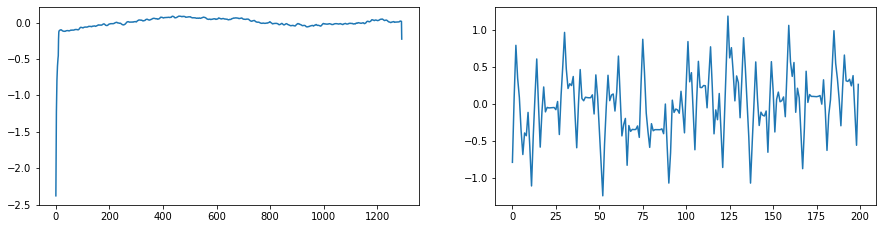

In [618]:
plt.figure(figsize=(15, 8)) 
plt.subplot(2,2,1)
plt.plot(ts1)
plt.subplot(2,2,2)
plt.plot(ts2)
plt.show()

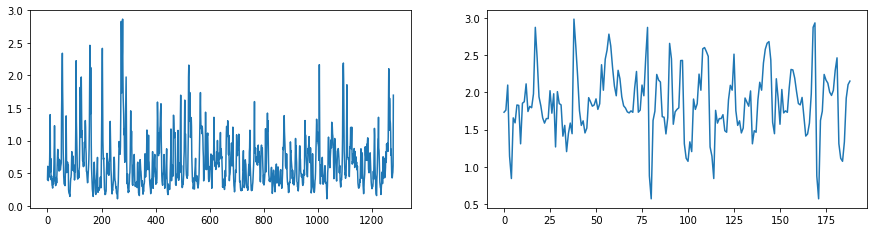

In [619]:
w = 12
mp1, mpi1 = matrixProfile.stomp(ts1, w)
mp2, mpi2 = matrixProfile.stomp(ts2, w)

plt.figure(figsize=(15, 8)) 
plt.subplot(2,2,1)
plt.plot(mp1)
plt.subplot(2,2,2)
plt.plot(mp2)
plt.show()

Parameters
- max_motifs: stop finding new motifs once we have max_motifs
- radius: For each motif found, find neighbors that are within radius*motif_mp of the first.
- n_neighbors: number of neighbors from the first to find. If it is None, find all.
- ex_zone: minimum distance between indices for after each subsequence is identified. Defaults to m/2 where m is the subsequence length. If ex_zone = 0, only the found index is exclude, if ex_zone = 1 then if idx is found as a motif idx-1, idx, idx+1 are excluded.

Returns
The function returns a tuple (top_motifs, distances) which are lists of the same length.

- top_motifs: This is a list of the indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [684]:
mo1, mod1  = motifs.motifs(ts1, (mp1, mpi1), max_motifs=10)
mo2, mod2  = motifs.motifs(ts2, (mp2, mpi2), max_motifs=6)

In [685]:
mo1, mod1, mo2, mod2

([[259, 1034],
  [83, 169, 988],
  [340, 979, 1218],
  [189, 213, 446],
  [179, 557, 692, 928, 1234],
  [239, 716],
  [328, 382, 1170, 1201],
  [832, 1150],
  [299, 354, 651, 730, 892]],
 [0.10654442493113031,
  0.14294242247921798,
  0.1562098683700056,
  0.17135205040340631,
  0.17302996553645425,
  0.18191164189964004,
  0.1853733671076522,
  0.18931531569712884,
  0.20248489261303385],
 [[80, 171],
  [4, 114],
  [32, 47, 100, 132, 184],
  [13, 87, 144, 164],
  [72, 121],
  [22, 151]],
 [0.5669597980368914,
  0.8403280471771819,
  1.072216891404487,
  1.4125024304104539,
  1.4640702759839386,
  1.5868231364978513])

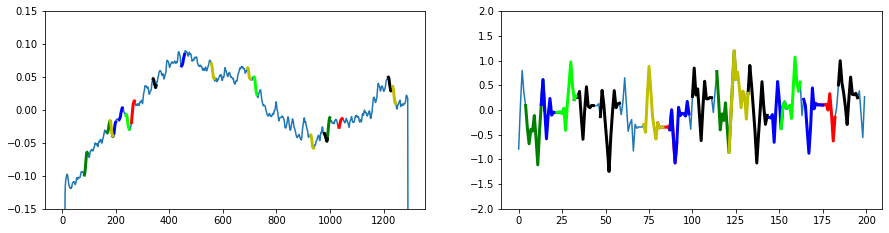

In [691]:
plt.figure(figsize=(15, 8)) 
plt.subplot(2,2,1)
plt.plot(ts1)
plt.ylim([-.15,.15])
colors1 = ['r', 'g', 'k', 'b', 'y', 'lime', 'm', 'darkorange', 'tab:brown'][:len(mo1)]
for m, d, c in zip(mo1, mod1, colors):
    for i in m:
        m_shape = ts1[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.subplot(2,2,2)
plt.plot(ts2)
plt.ylim([-2,2])
colors2 = ['r', 'g', 'k', 'b', 'y', 'lime', 'm', 'darkorange', 'tab:brown'][:len(mo2)]
for m, d, c in zip(mo2, mod2, colors):
    for i in m:
        m_shape = ts2[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)
        
plt.show()

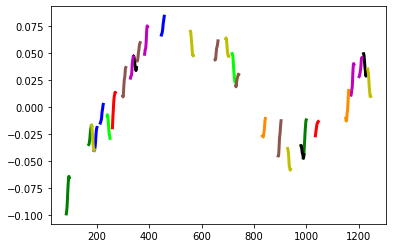

In [711]:
#plt.figure(figsize=(100, 80))
n=1
for m, d, c in zip(mo1, mod1, colors1):
    #plt.subplot(len(mod1),len(mod1),n)
    n=n+1
    for i in m:
        m_shape = ts1[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

#plt.tight_layout()        
plt.show()

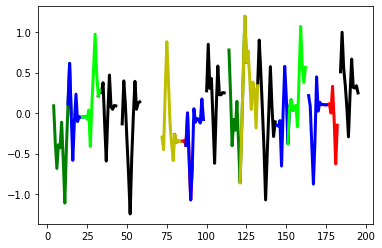

In [710]:
n=1
for m, d, c in zip(mo2, mod2, colors2):
    #plt.subplot(len(mod1),len(mod1),n)
    n=n+1
    for i in m:
        m_shape = ts2[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

## Anomaly Discovery

In [713]:
from matrixprofile.discords import discords

Parameters  
- mp: matrix profile numpy array
- k: the number of discords to discover
- ex_zone: the number of samples to exclude and set to Inf on either side of a found discord    

Returns 
 - a list of indexes represent the discord starting locations. MaxInt indicates there were no more discords that could be found due to too many exclusions or profile being too small. Discord start indices are sorted by highest matrix profile value.

In [714]:
anoms = discords(mp1, ex_zone=3, k=5)

In [715]:
anoms

array([278, 273, 157, 203,  55])

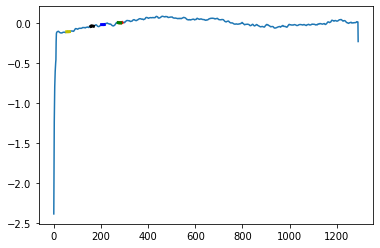

In [716]:
plt.plot(ts1)
colors = ['r', 'g', 'k', 'b', 'y'][:len(mo1)]
for a, c in zip(anoms, colors):
    a_shape = ts1[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()